In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.morphology import binary_closing, binary_dilation, disk
from skimage.segmentation import clear_border
from skimage.io import imread


# Set the path to the folder containing the images
image_folder = 'Data\Exp_grp'

# Get a list of all the image files in the folder
image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')])

# Load the first image and extract the binary image of cells
first_frame = imread(image_files[0], as_gray=True)
threshold = threshold_otsu(first_frame)
binary_frame = first_frame > threshold
binary_frame = binary_closing(binary_frame, disk(3))
binary_frame = clear_border(binary_frame)
binary_frame = binary_dilation(binary_frame, disk(5))

# Label the cells in the first frame
labeled_frame = label(binary_frame)
cell_props = regionprops(labeled_frame)

# Loop over the remaining frames and track the cells
for i in range(1, len(image_files)):
    # Load the current image and extract the binary image of cells
    current_frame = imread(image_files[i], as_gray=True)
    threshold = threshold_otsu(current_frame)
    binary_frame = current_frame > threshold
    binary_frame = binary_closing(binary_frame, disk(3))
    binary_frame = clear_border(binary_frame)
    binary_frame = binary_dilation(binary_frame, disk(5))

    # Label the cells in the current frame
    labeled_frame = label(binary_frame)
    current_props = regionprops(labeled_frame)

    # Match cells in the current frame to cells in the previous frame
    for cell in current_props:
        overlaps = [cell.overlap(other) for other in cell_props]
        if max(overlaps) > 0.5:
            cell_idx = overlaps.index(max(overlaps))
            cell.label = cell_props[cell_idx].label

    # Update the list of cell properties with the properties from the current frame
    cell_props = current_props

    # Save the labeled image with cell tracking information
    plt.imshow(current_frame)
    for cell in cell_props:
        plt.text(cell.centroid[1], cell.centroid[0], cell.label, color='r')
    plt.savefig(f'tracked_cells_{i:03d}.jpg')
    plt.clf()  # Clear the figure to avoid plotting on top of the previous image



AttributeError: '<class 'skimage.measure._regionprops.RegionProperties'>' object has no attribute 'overlap'

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.morphology import binary_closing, binary_dilation, disk
from skimage.segmentation import clear_border
from skimage.io import imread


# Set the path to the folder containing the images
image_folder = 'Data/Exp_grp/'

# Get a list of all the image files in the folder
image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')])

# Load the first image and extract the binary image of cells
first_frame = imread(image_files[0], as_gray=True)
threshold = threshold_otsu(first_frame)
binary_frame = first_frame > threshold
binary_frame = binary_closing(binary_frame, disk(3))
binary_frame = clear_border(binary_frame)
binary_frame = binary_dilation(binary_frame, disk(5))

# Label the cells in the first frame
labeled_frame = label(binary_frame)
cell_props = regionprops(labeled_frame)

# Loop over the remaining frames and track the cells
for i in range(1, len(image_files)):
    # Load the current image and extract the binary image of cells
    current_frame = imread(image_files[i], as_gray=True)
    threshold = threshold_otsu(current_frame)
    binary_frame = current_frame > threshold
    binary_frame = binary_closing(binary_frame, disk(3))
    binary_frame = clear_border(binary_frame)
    binary_frame = binary_dilation(binary_frame, disk(5))

    # Label the cells in the current frame
    labeled_frame = label(binary_frame)
    current_props = regionprops(labeled_frame)

    # Match cells in the current frame to cells in the previous frame
    for cell in current_props:
        overlaps = [np.sum(np.logical_and(cell.bbox, other.bbox)) for other in cell_props]
        if max(overlaps) > 0.5*cell.area:
            cell_idx = overlaps.index(max(overlaps))
            cell.label = cell_props[cell_idx].label

    # Update the list of cell properties with the properties from the current frame
    cell_props = current_props

    # Save the labeled image with cell tracking information
    plt.imshow(current_frame)
    for cell in cell_props:
        plt.text(cell.centroid[1], cell.centroid[0], cell.label, color='r')
    plt.savefig(f'tracked_cells_{i:03d}.jpg')
    plt.clf()  # Clear the figure to avoid plotting on top of the previous image



<Figure size 640x480 with 0 Axes>

# Saving Paths to csv

In [61]:
import os
import numpy as np
import pandas as pd
import skimage.io
import skimage.measure
import skimage.segmentation

# Define the path to the folder containing the images
image_folder = 'Data/Exp_grp/'

# Load the list of image files in the folder
image_files = sorted(os.listdir(image_folder))
image_files = [f for f in image_files if f.endswith(".jpg")]

# Initialize an empty dataframe to store the cell properties for each frame
cell_props_all = pd.DataFrame()

# Process each image file in the folder
for i, image_file in enumerate(image_files):

    # Load the image
    image_path = os.path.join(image_folder, image_file)
    image = skimage.io.imread(image_path)

    # Segment the cells using Otsu thresholding
    thresh = skimage.filters.threshold_otsu(image)
    binary = image > thresh

    # Remove small objects
    binary = skimage.morphology.remove_small_objects(binary, min_size=100)

    # Label the objects in the binary image
    labels = skimage.measure.label(binary)

    # Measure properties of the labeled objects
    cell_props = skimage.measure.regionprops_table(labels, properties=("label", "centroid"))

    # Add the frame number to the dataframe
    cell_props = pd.DataFrame(cell_props)
    cell_props["frame"] = i

    # Append the cell properties for this frame to the dataframe for all frames
    cell_props_all = pd.concat([cell_props_all, cell_props])

# Convert the centroid coordinates to a more readable format
cell_props_all["centroid"] = list(zip(cell_props_all["centroid-1"], cell_props_all["centroid-0"]))

# Match cells in each frame to cells in the previous frame, based on centroid distance
cell_groups = []
for i in range(1, len(image_files)):
    prev_props = cell_props_all[cell_props_all["frame"] == i-1]
    current_props = cell_props_all[cell_props_all["frame"] == i]
    groups = []
    for cell in current_props.itertuples():
        distances = [np.linalg.norm(np.array(cell.centroid) - np.array(other.centroid)) for other in prev_props.itertuples()]
        if len(distances) > 0 and min(distances) < 50:
            group_idx = np.argmin(distances)
            groups.append(group_idx)
    cell_groups.append(groups)

# Add a column to the dataframe indicating the cell ID for each frame
cell_props_all["cell_id"] = -1
cell_id = 0
for i, groups in enumerate(cell_groups):
    for group_idx in groups:
        cell_props_all.loc[(cell_props_all["frame"] == i+1) & (cell_props_all.index == group_idx), "cell_id"] = cell_id
        cell_id += 1

# Save the cell properties to a CSV file
cell_props_all.to_csv("cell_props.csv", index=False)


KeyboardInterrupt: 

Index(['label', 'centroid-0', 'centroid-1', 'frame'], dtype='object')


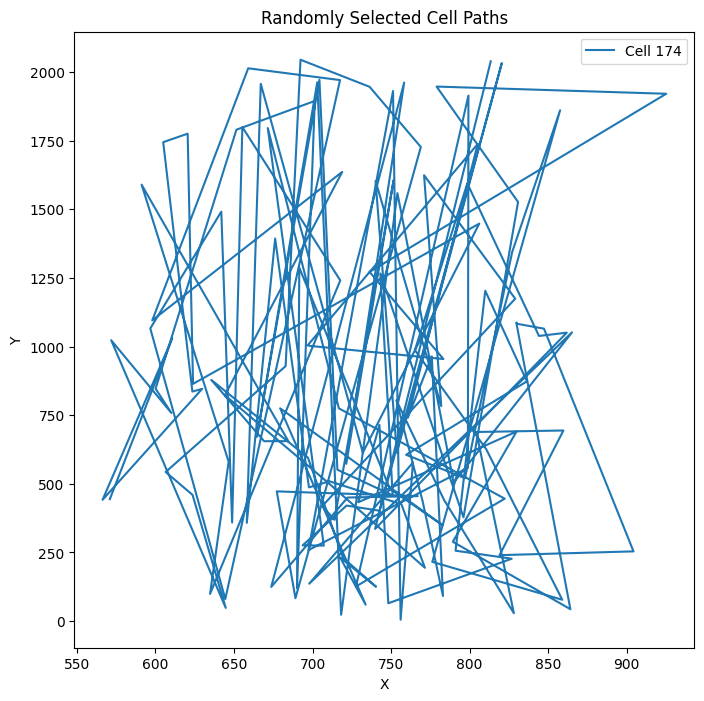

In [52]:
import matplotlib.pyplot as plt
import numpy as np
# Load data
df = pd.read_csv('cell_props.csv')

# randomly select 4 cell IDs
labels = np.random.choice(df['label'].unique(), size=1, replace=False)

# plot the paths for each of the selected cells
fig, ax = plt.subplots(figsize=(8,8))
for label in labels:
    # get the data for this cell
    cell_data = df[df['label']==label]
    # plot the path
    ax.plot(cell_data['centroid-0'], cell_data['centroid-1'], label=f"Cell {label}")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Randomly Selected Cell Paths')
ax.legend()
plt.show()



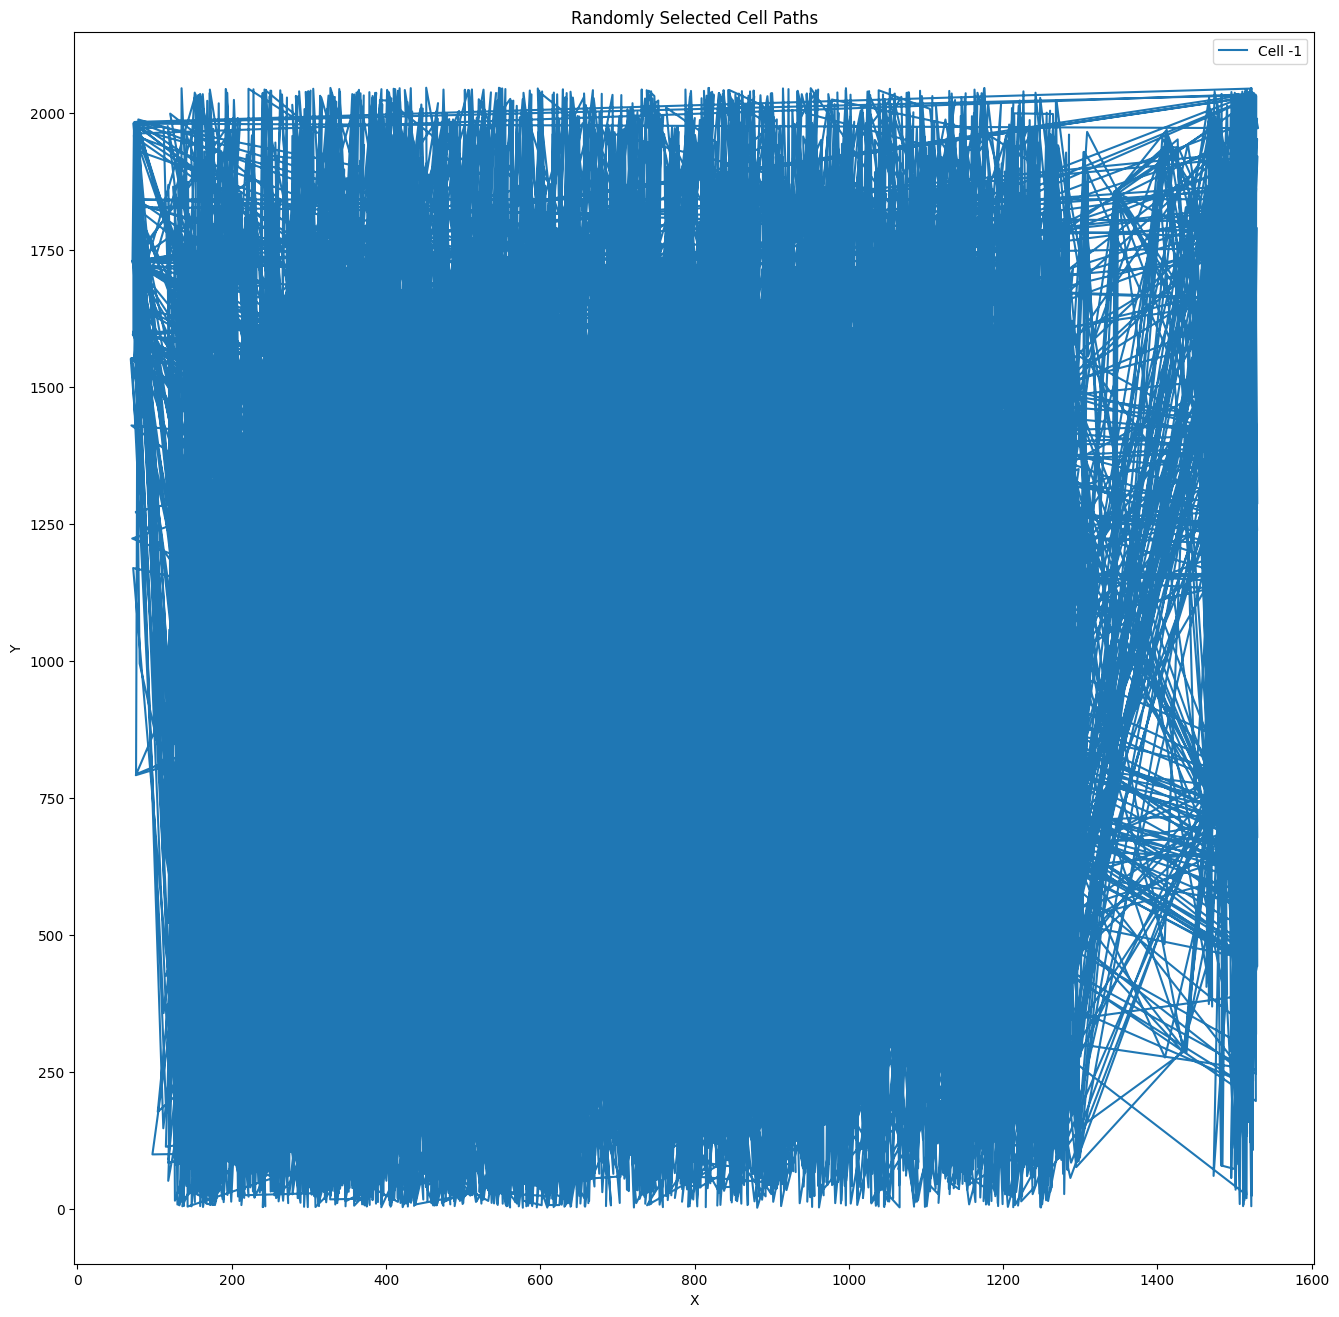

In [60]:
import matplotlib.pyplot as plt
import numpy as np
# Load data
df = pd.read_csv('cell_props.csv')

# randomly select 4 cell IDs
# labels = np.random.choice(df['cell_id'].unique(), size=2, replace=False)
labels = [-1]
# plot the paths for each of the selected cells
fig, ax = plt.subplots(figsize=(16,16))
for label in labels:
    # get the data for this cell
    cell_data = df[df['cell_id']==label]
    # plot the path
    ax.plot(cell_data['centroid-0'], cell_data['centroid-1'], label=f"Cell {label}")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Randomly Selected Cell Paths')
ax.legend()
plt.show()

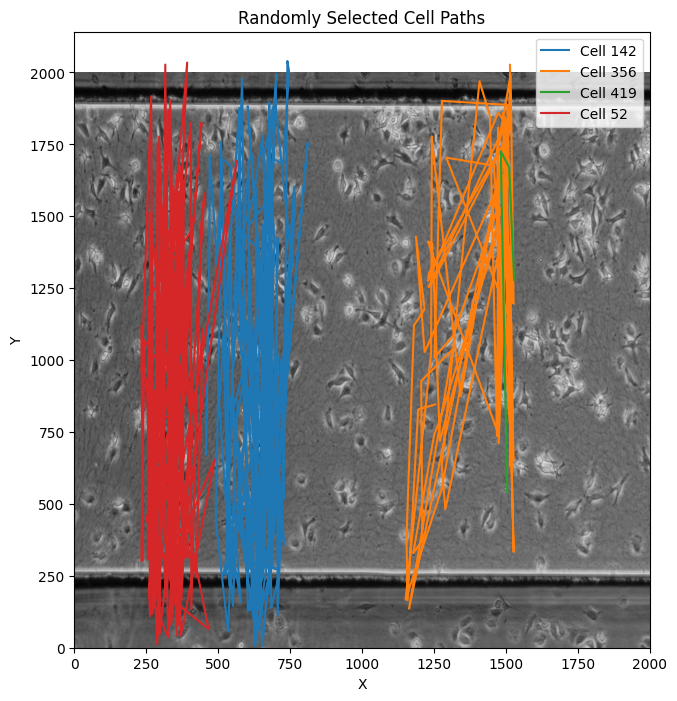

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load data
df = pd.read_csv('cell_props.csv')

# Load initial image
image = plt.imread('Data\Exp_grp\image001.jpg')
# Display the image as the background

# randomly select 4 cell IDs
labels = np.random.choice(df['label'].unique(), size=4, replace=False)

# plot the paths for each of the selected cells
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(image,extent=[0, 2000, 0, 2000], cmap='gray')
for label in labels:
    # get the data for this cell
    cell_data = df[df['label']==label]
    # plot the path
    ax.plot(cell_data['centroid-0'] , cell_data['centroid-1'], label=f"Cell {label}")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Randomly Selected Cell Paths')
ax.legend()
plt.show()


In [38]:
print(cell_data['centroid-0'].min(), cell_data['centroid-0'].max(), cell_data['centroid-1'].min(), cell_data['centroid-1'].max())


559.7373226267737 559.7373226267737 754.9704102958971 754.9704102958971
